# CSS Lab: Network Structure
This lab demonstrates how to use common tools to analyze the structure of several networks. Topics covered include visualization, centrality measures, shortest paths, and affiliation networks. At the end of the lab, you will be able to visualze and perform an analysis of your own social network.

## Contents

1. [Background](#Section-1%3a-Background)
1. [Setup](#Section-2%3a-Setup)
4. [Community Structure](#Section-3%3a-Community-Structure)
6. [Affiliation Networks](#Section-4%3a-Affiliation-Networks)
    * [4.1 Weighted Edges](#4.1-Weighted-Edges)
5. [Paths](#Section-5%3a-Paths)
    * [5.1 Find Path Lengths](#5.1-Find-Path-Lengths)
    * [5.2 Bridges and Weak Ties](#5.2-Bridges-and-Weak-Ties)
    * [5.3 Find Minimum Cut](#5.3-Find-Minimum-Cut)
7. [Your Social Network](#Section-6%3a-Your-Social-Network)
    * [6.1 Communities](#6.1-Communities)
    * [6.2 Find Giant Component](#6.2-Find-Giant-Component)
    * [6.3 Path Lengths](#6.3-Path-Lengths)
    * [6.4 Find Bridges](#6.4-Find-Bridges)
8. [Reflection](#Section-7%3a-Reflection)
1. [References](#References)
    


## Section 1: Background
Looking at the structure of a network takes a step back from the properties of individual nodes to identify larger-scalae patterns. This notebook explores several ways of measuring network structure. This lab will continue using a data set of group memberships from the American Revolution (Healey2013). Additionally, this lab analyzes a fictional network of complex political relationships, namely the characters in George R.R. Martin's _A Storm of Swords_ (BS2016). The _Storm of Swords_ network was created by creating links between two characters if they are mentione at the same time.

## Section 2: Setup
We import several libraries, including `networkx` for network algorithms, `pandas` for data processing, and `vis` for visualization. We also define some helper functions used by several of the sections.

In [180]:
%pylab inline
import itertools
from IPython.display import display, Javascript, HTML
import json
import math
import urllib.request
import networkx as nx
import networkx as networkx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


The following cell imports `vis.js`, the visualization library used by this lab.

**Note**: if you get an error, `Javascript Error: require is not defined`, it is likely because you are running this notebook in `jupyter lab`. You need to shut down `jupyter lab`, start `jupyter notebook` instead, and then run this notebook. This error should not happen in `jupyter notebook`.

In [181]:
%%javascript
require.config({
    paths: {
        vis: 'https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis'
    }
});

<IPython.core.display.Javascript object>

Load custom CSS for `vis`.

In [182]:
HTML('<style>{}</style>'.format(open('custom.css').read()))

In [183]:
# Helper functions

# Standardize a vector to 0 mean and unit variance
def scale(v):
    return (v - v.mean()) / v.std()

# Return a data frame sorted by a node's centrality relative the mean of its centralities
def rel_centrality(df, measure, labels=dict()):
    name = 'rel_{}'.format(measure)
    return pd.DataFrame({
        name: scale(df[measure]) / df['mean_centrality'],
        "label": [labels.get(x, x) for x in df.index]
    })

def path_histogram(G, log=False):
    # Find shortest path length for each pair
    path_lengths = list(itertools.chain(*[
            [length for length in targets.values() if length > 0]
        for source, targets in list(nxalg.shortest_path_length(G))]))
    # Draw histogram with integer bins
    bins = [0.5 + x for x in range(max(path_lengths)+1)]
    counts, centers, patches = plt.hist(
        path_lengths, bins=bins, rwidth=0.8)
    if log:
        plt.yscale('log', nonposy='clip')
        ymax = np.power(10, np.ceil(np.log10(max(counts))))
    else:
        place = np.power(10, np.floor(np.log10(max(counts))))
        ymax = np.ceil(max(counts) / place) * place
    # Plot average shortest path length
    mean_path = nxalg.average_shortest_path_length(G)
    plt.plot([mean_path, mean_path], [1, ymax], label="mean")
    plt.ylim([1, ymax])
    plt.xlabel("Path length")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

def longest_geodesic(G):
    paths = nxalg.shortest_path(G)
    longest = 0
    longest_path = []
    for source, source_paths in paths.items():
        for target, path in source_paths.items():
            if len(path) > longest:
                longest = len(path)
                longest_path = path
    return path

# Helper functions

def find_bridges(G, labels=None):
    bridges = []
    for v, w in G.edges():
        H = G.copy()
        H.remove_edge(v, w)
        try:
            d = nx.shortest_path_length(H, source=v, target=w)
            if d <= 2:
                continue
        except nx.NetworkXNoPath:
            d = float("Inf")
        if labels is None:
            bridges.append((d, v, w))
        else:
            bridges.append((d, labels[v], labels[w]))
    bridges = sorted(bridges, key=lambda x: x[0], reverse=True)
    for b in bridges:
        if b[0] == float("Inf"):
            print("Global bridge:\t{} <-> {}".format(b[1], b[2]))
        else:
            print("Local bridge, span {}:\t{} <-> {}".format(*b))
            
def find_global_bridges(G, labels=None):
    bridges = nx.algorithms.bridges(G)
    for b in bridges:
        if labels is None:
            v, w = b[0], b[1]
        else:
            v, w = labels[b[0]], labels[b[1]]
        print("Global bridge:\t{} <-> {}".format(v, w))

def get_colors():
    phi = (1 + math.sqrt(5)) / 2
    color = []
    for i in range(1, 20):
        theta = phi * i * math.pi * 2
        x = 128 + math.floor(64*math.sin(theta))
        y = 128 + math.floor(64*math.cos(theta))
        color.append((x, x, y))
    return color

def visjs_network(
        nodes_list,
        edges_dict,
        node_size_field=None,
        node_size_multiplier=1,
        edge_width_field=None,
        edge_width=None,
        edge_arrow_to=None,
        edge_arrow_to_scale_factor=1,
        edge_smooth_enabled=False,
        edge_smooth_type="curvedCW",
        graph_id="vis-output"):
    
    # Configure nodes
    for node in nodes_list:
        if node_size_field is not None:
            node['size'] = node[node_size_field] * node_size_multiplier
        node['title'] = node['label']
        node['font'] = { 'size': 14 }
        node['shadow'] = True
    node_json = json.dumps(nodes_list)
    
    # Configure edges
    for edge in edges_dict:
        color = edge['color']
        edge['color'] = {
            'color': color
        }
    edge_json = json.dumps(edges_dict)

    js = Javascript("""
(function(element) {{
    require(['vis'], function(vis) {{
      // create an array with nodes
      var nodes = new vis.DataSet({});
      console.log(nodes)

      // create an array with edges
      var edges = new vis.DataSet({});
      console.log(edges)

      // create a network
      var id = 'container-' + {}
      element.append('<div style="width:800px;height:800px" id="' + id + '">hi</div>')
      var container = document.getElementById(id);
      element.append(container)
      var data = {{
        nodes: nodes,
        edges: edges
      }};
      var options = {{
          physics: {{
              enabled: false
          }},
          interaction: {{
              hover: true
          }}
      }};
      var network = new vis.Network(container, data, options);
    }})
}})(element);
    """.format(node_json, edge_json, graph_id))
    return js

def visualize_visjs(
        G, communities=None, colors=None, default_color="192,192,192",
        node_size_field="node_size", layout="spring", scale=500, pos=None,
        groups=None, weight=None, labels=dict(), edge_width_field="value", title=""):
    # Get list of nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())
    # Change node shapes for bipartite graph
    if groups is None:
        node_shapes = dict()
        node_sizes = dict()
        node_colors = dict()
    else:
        node_shapes = dict((n, "square") for n in groups)
        node_sizes = dict((n, 5) for n in groups)
        node_colors = dict((n, "192,128,0") for n in groups)
    # Per-node properties
    nodes_dict = dict((n, {
        "id": n,
        "label": labels.get(n, n),
        "node_size": node_sizes.get(n, 5),
        "shape": node_shapes.get(n, "dot")
        }) for n in nodes)
    # Generate a layout for the nodes
    edge_smooth_enabled = False
    edge_width = 4
    edge_arrow_scale = 2
    if communities is not None and pos is None:
        # Generate initial positions based on community
        phi = 3.14 / len(nodes)
        community_node = []
        # Create list of nodes and their communities
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                community_node.append((i, node))
        # Sort by community and
        community_node = sorted(community_node)
        # Generate initial position by placing communities around a circle
        pos = dict((d[1], (math.cos(i*phi), math.sin(i*phi))) for i, d in enumerate(community_node))
    else:
        pos = None
    if layout == "circle":
        pos = nx.circular_layout(G, scale=scale)
    elif layout == "spring":
        pos = nx.spring_layout(G, k=3/math.sqrt(len(nodes)), scale=scale, pos=pos)
    else:
        edge_smooth_enabled = True
    # Assign position
    for n in nodes:
        nodes_dict[n]["x"] = pos[n][0]
        nodes_dict[n]["y"] = pos[n][1]
    # Calculate bounds for scaling
    x_min = min(pos.values(), key=lambda x: x[0])[0]
    x_max = max(pos.values(), key=lambda x: x[0])[0]
    y_min = min(pos.values(), key=lambda x: x[1])[1]
    y_max = max(pos.values(), key=lambda x: x[1])[1]
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    # If we have communities, assign color based on community
    if colors is None:
        colors = ["{},{},{}".format(*c) for c in get_colors()]
    if communities is not None:
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                try:
                    nodes_dict[node]["color"] = "rgba({},1)".format(colors[i])
                    nodes_dict[node]["color_index"] = i
                except IndexError:
                    nodes_dict[node]["color"] = "rgba({},1)".format(default_color)
    # Update color for bipartite nodes
    for node, node_attr in nodes_dict.items():
        if node in node_colors:
            node_attr["color"] = "rgba({},1)".format(node_colors[node])
    # Map node labels to contiguous ids
    node_map = dict(zip(nodes,range(len(nodes))))
    # Determine edge colors
    edge_colors_idx = {}
    for source, target in edges:
        source_color = nodes_dict[source].get("color_index", None)
        target_color = nodes_dict[target].get("color_index", None)
        if source_color == target_color and source_color is not None:
            edge_colors_idx[(source, target)] = source_color
    edge_colors = dict(
        (e,colors[c])
        for e, c in edge_colors_idx.items() if c < len(colors))
    # Per-edge properties, use contiguous ids to identify nodes
    edge_scale = math.ceil(max_range / 200)
    edges_dict = []
    for source, target, data in G.edges(data=True):
        edge = {
            "from": source,
            "to": target,
            "color": "rgba({},0.3)".format(edge_colors.get((source,target), default_color)),
            "edge_width_field": edge_width_field,
            "value": data.get(edge_width_field, 1) * edge_scale
        }
        edges_dict.append(edge)
    # Convert nodes dict to node list
    nodes_list = [nodes_dict[n] for n in nodes]
    # Check for directed graph
    if G.__class__ == nx.classes.digraph.DiGraph:
        directed = True
    else:
        directed = False
    # Call visjs
    return visjs_network(
        nodes_list, edges_dict,
        node_size_field="node_size",
        node_size_multiplier=10.0,
        edge_width_field="value",
        edge_width=edge_width,
        edge_arrow_to=directed,
        edge_arrow_to_scale_factor=edge_arrow_scale,
        edge_smooth_enabled=edge_smooth_enabled,
        edge_smooth_type="curvedCW",
        graph_id=hash(title))

## Section 3: Community Structure

People are often organized into groups where everyone is highly-connected: schools, workplaces, clubs, etc. What if you know the connections between individuals and want to discover the groups? This is the problem of _community detection_. There are many ways to find communities. The following cells find and visualize communities using a method that maximizes _modularity_ (CNM2004). Networks with high modularity have a high number of edges between nodes in the same community and a low number of edges across communities. One benefit of this method is that it automatically determines the best number of communities.

We'll continue using the network from the previous lab, composed of organizations from the American Revolution. In the visualization below, different communities are shown in different colors.

In [184]:
# Helper functions

def load_revere_affiliation(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv"):
    data = urllib.request.urlopen(url)
    df = pd.read_csv(data).set_index("Unnamed: 0")
    people = list(df.index)
    groups = list(df.columns)
    #
    B = nx.Graph()
    for column in df.columns:
        for row in df[df[column] == 1].index:
            B.add_edge(column, row)
    return people, groups, B

def load_revere(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv",
        threshold=None, dual=False):
    # Load the affiliation network
    people, groups, B = load_revere_affiliation(url)
    # Project the affiliation network onto the set of people
    if dual:
        G = nxalg.bipartite.projection.weighted_projected_graph(B, groups)
    else:
        G = nxalg.bipartite.projection.weighted_projected_graph(B, people)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    # Copy "weight" data to "value" needed by visjs
    w = nx.get_edge_attributes(G, "weight")
    nx.set_edge_attributes(G, w, "value")
    return G

In [185]:
people, groups, B_revere = load_revere_affiliation()
G_revere = load_revere()
communities = list(nxcom.greedy_modularity_communities(G_revere))
visualize_visjs(G_revere, communities=communities, scale=3000, title="Community Detection Example")


<IPython.core.display.Javascript object>

#### Short Answer 1
Consider the communities represented by each color in the visualization. It may be helpful to see lists of the organizations each individual belonged to, the cell below can be used to do so. Do any communities correspond to particular organizations (or groups of organizations)? Have any organizations been combined into the same community? If so, why would two organizations be combined?

In [186]:
list(nx.neighbors(B_revere, "Church.Benjamin"))

['NorthCaucus', 'LongRoomClub', 'BostonCommittee', 'LondonEnemies']

🤔 Your answer here:

## Section 4: Affiliation Networks
Sometimes it is useful to consider two different types of nodes.
Often, this is the case when one type of node represents groups and the other represents members of those groups,
with the edges representing membership.
Such networks are called affiliation networks.
The American Revolution data from before was created from an affiliation network.
The cell below visualizes the full affiliation network.
Notice that person nodes are only connected to group nodes and vice versa.

In [187]:
peopele, groups, B_revere = load_revere_affiliation()
visualize_visjs(B_revere, scale=3000, groups=groups, title="American Revolution Affiliation")

<IPython.core.display.Javascript object>

Previously, this affilation network was used to create a network connecting people to people.
But we can just as easily create a network connecting groups to groups (if they have a common member) [Breiger1974]. 

In [188]:
G_dual = load_revere(dual=True)
visualize_visjs(G_dual, title="American Revolution Groups", edge_width_field=None, groups=G_dual.nodes())

<IPython.core.display.Javascript object>

### 4.1 Weighted Edges
In the above example, two groups have an edge between them if they have a common member.
But some groups might have only one member in common, while others have many.
These differences can be represented by adding a _weight_ do the edge.
Edge weights can be used to represent many different properties, such as distance or similarity.
In this case, weights represent how many members two groups have in common.

In [189]:
visualize_visjs(G_dual, title="American Revolution Weighted", groups=G_dual.nodes(), weight="weight")

<IPython.core.display.Javascript object>

## Section 5: Paths

It is also informative to consider the shortest paths of a network.
For a pair of nodes, the shortest path is the path connecting them in the fewest number of hops.
The example below uses a network of characters from the novel _A Storm of Swords_ (BS2016),
with edges representing characters mentioned at the same time.

In [190]:
# Helper functions

def load_asoiaf():
    G = nx.Graph()
    try:
        with open("external/stormofswords.csv") as f:
            f.readline()
            rows = list(f)
    except FileNotFoundError:
        url = 'https://www.macalester.edu/~abeverid/data/stormofswords.csv'
        response = urllib.request.urlopen(url)
        data = response.read()
        with open('external/stormofswords.csv', 'wb') as f:
            f.write(data)
        with open("external/stormofswords.csv") as f:
            f.readline()
            rows = list(f)
    for row in rows:
        source, target, weight = row.split(",")
        G.add_edge(source, target, weight=int(weight), capacity=1)
    return G

First, load and visualize the network.

In [191]:
G_asoiaf = load_asoiaf()
visualize_visjs(G_asoiaf, title="asoiaf", scale=2000)

<IPython.core.display.Javascript object>

### 5.1 Path Lengths
Next, plot a histogram of the path lengths as well as the mean path length. The diameter of a network is the length of the longest shortest path.

#### Short Answer 2
Write a few sentences about the distance (number of edges) between nodes in this network, considering the following. How long would you guess the typical shortest path between two nodes is? How long would you guess the shortest path is between the two most distance nodes?

🤔 Your answer here:

#### Finding Path Lengths 
Now we will calculate the actual distribution of path lengths.

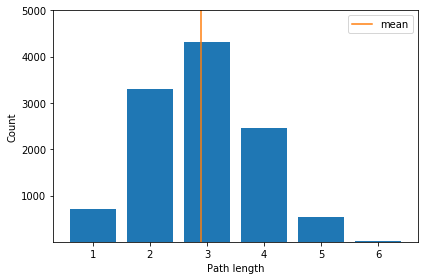

In [192]:
path_histogram(G_asoiaf)

The cell above found the distribution of paths lengths, but it is also informative to look at individual paths. The following cell prints the shortest path between the two most distant nodes in the network. You might expect the endpoints to be very different in some way, perhaps separated geographically, or socially. Similarly the nodes in the middle are ones that connect distant parts of the network, and are likely to play an important role in the network.

In [193]:
print(longest_geodesic(G_asoiaf))

['Walton', 'Jaime', 'Arya', 'Jon', 'Craster', 'Karl']


### 5.2 Bridges and Weak Ties
We can also find edges which act as bridges between different parts of the network. An edge is a bridge if removing it disconnects two parts of a network.
More generally, a local bridge connects two nodes that would otherwise be far apart.
If removing an edge causes its endpoints to become distance _n_ apart,
it is called a local bridge of span n.

Bridges are often _weak ties_ (Granovetter1977) because individuals with a strong connection are likely to have common friends.

In [194]:
find_global_bridges(G_asoiaf)

Global bridge:	Jaime <-> Qyburn
Global bridge:	Jaime <-> Walton
Global bridge:	Tyrion <-> Doran
Global bridge:	Amory <-> Oberyn
Global bridge:	Jon <-> Orell
Global bridge:	Belwas <-> Illyrio
Global bridge:	Robb <-> Ramsay
Global bridge:	Craster <-> Karl
Global bridge:	Daenerys <-> Aegon
Global bridge:	Daenerys <-> Kraznys
Global bridge:	Daenerys <-> Rakharo
Global bridge:	Daenerys <-> Worm
Global bridge:	Davos <-> Cressen
Global bridge:	Davos <-> Salladhor
Global bridge:	Davos <-> Shireen
Global bridge:	Kevan <-> Lancel


### 5.3 Find Minimum Cut
Sometimes you might want to know where a network is most fragile.
The minimum cut finds the fewest number of links that need to be removed to break a network into two pieces.
In the beginning of the _A Song of Ice and Fire_ series, exiled princess Daenerys Targaryen and her brother Viserys seek to reclaim the throne from reigning king Robert Baratheon.
You can use the minimum cut to find the links that separate characters connected to the Targaryens from those more closely connected to the Baratheons.

First we find the minimum cut: the number of edges separating the two factions.

In [195]:
mincut, cuts = nxalg.minimum_cut(G_asoiaf, 'Daenerys', 'Robert')
mincut

6

Now we can visualize the min cut. Who in the "Robert" cluster is closest to members of the "Daenerys" cluster? 

In [196]:
visualize_visjs(G_asoiaf, communities=cuts, scale=2000, title="Mincut")

<IPython.core.display.Javascript object>

## Section 6: Core-Periphery Structure

In many real-world networks, we observe two qualitatively distinct components: a dense “core” of tightly connected nodes and a sparse “periphery” of nodes loosely connected to the core and among each other (Gallagher2021). There are a number of methods for analytically identifying the core and periphery nodes in a network. Next, we introduce **K-cores** which is one such method.

### K-Core

The **K-core** of a network is the largest sub-network of that network such that each node in the new network is connected to at least **K** other nodes. Building on this definition, the **coreness** or **core number** of a node in the original network is the highest *K* for which the corresponding K-core contains the node. Nodes that have low coreness are in the periphery of the network while those that have higher coreness are closer to the core. 

In [197]:
#You can use the following networkx function to extract the K-core for any K value as a new 
#network. If the K value you submit exceeds the largest K value of the most well-connected 
#sub-network the function will throw an error.
g=nx.k_core(G_asoiaf,k=2)
visualize_visjs(g, title="asoiaf", scale=2500)

<IPython.core.display.Javascript object>

In [198]:
#You can get the core number of all nodes in the network with the following networkx 
#function
nx.core_number(G_asoiaf).items()

dict_items([('Aemon', 4), ('Grenn', 3), ('Samwell', 4), ('Aerys', 4), ('Jaime', 7), ('Robert', 7), ('Tyrion', 7), ('Tywin', 7), ('Alliser', 3), ('Mance', 4), ('Amory', 1), ('Oberyn', 4), ('Arya', 7), ('Anguy', 2), ('Beric', 4), ('Bran', 6), ('Brynden', 5), ('Cersei', 7), ('Gendry', 4), ('Gregor', 7), ('Joffrey', 7), ('Jon', 6), ('Rickon', 5), ('Roose', 4), ('Sandor', 7), ('Thoros', 4), ('Balon', 6), ('Loras', 6), ('Belwas', 3), ('Barristan', 3), ('Illyrio', 1), ('Hodor', 4), ('Jojen', 4), ('Luwin', 2), ('Meera', 4), ('Nan', 2), ('Theon', 4), ('Brienne', 6), ('Bronn', 4), ('Podrick', 4), ('Lothar', 4), ('Walder', 5), ('Catelyn', 7), ('Edmure', 5), ('Hoster', 3), ('Jeyne', 2), ('Lysa', 6), ('Petyr', 6), ('Robb', 7), ('Roslin', 4), ('Sansa', 7), ('Stannis', 7), ('Elia', 4), ('Ilyn', 6), ('Meryn', 6), ('Pycelle', 4), ('Shae', 4), ('Varys', 5), ('Craster', 4), ('Karl', 1), ('Daario', 3), ('Drogo', 3), ('Irri', 3), ('Daenerys', 3), ('Aegon', 1), ('Jorah', 3), ('Kraznys', 1), ('Missandei', 2)

#### Short Answer 3

Imagine that George R.R. Martin, author of the ASOIAF series, had to edit the **Storm of Swords** to cut down its length slightly. He will have to drop at least 3 characters from the book in order to do. Which characters would you recommend (Give at least 3)? 

🤔 Your answer here:

#### Short Answer 4

Identify the most well-connected group of characters in the book by varying the *k* in the cell below. What is the k value of the most well-connected group? How many characters are in it? 

In [199]:
g=nx.k_core(G_asoiaf,k=7)
visualize_visjs(g, title="asoiaf", scale=2500)

<IPython.core.display.Javascript object>

🤔 Your answer here:

## Section 7: Reflection

#### Reflection Question 1
Because an email can have many recipients, an email communication network can be represented using an affiliation network. In such a network, what are the two types of nodes? What do edges between those nodes represent? Give an example of another type of data that can be modeled as an affiliation network and identify the nodes and edges.

🤔 Your answer here:

#### Reflection Question 2

Imagine that the Game of Thrones network was constructed from  interactions between characters rather than co-mentions in the text. What use would the information on the min-cut between Targaryen and Baratheon factions be to Daenerys? 

🤔 Your answer here:

#### Reflection Question 3
Your ego network includes your friends, but not friends of your friends. Consider two friends who are far apart in your ego network. What is their true distance from each other if they have a friend in common who is not in your ego network? If we only look at your ego network, are we overestimating or underestimating the true distance between individuals?

🤔 Your answer here:

## References

(Healey2013) Healy, K. 2013. "Using Metadata to Find Paul Revere." https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/

(CNM2004) Clauset, A., Newman, M. E., & Moore, C. (2004). Finding community structure in very large networks. Physical review E, 70(6).

(BS2016) A. Beveridge and J. Shan, "Network of Thrones," Math Horizons Magazine, Vol. 23, No. 4 (2016), pp. 18-22

(Breiger1974) Breiger, R. L. (1974). The duality of persons and groups. Social forces, 53(2), 181-190.

(Granovetter1977) Granovetter, M. S. (1977). The strength of weak ties. In Social networks (pp. 347-367).

(Gallagher2021) Gallagher, R. J., Young, J. G., & Welles, B. F. (2021). A clarified typology of core-periphery structure in networks. Science Advances, 7(12).